### Preparação do ambiente

Este projeto demanda a instalação dos pacotes **numpy, matplotlib e gym[all]**

### Preâmbulo do projeto

Importação de todos pacotes necessários

In [1]:
import gym, math, tqdm, numpy as np, matplotlib.pyplot as plt

### Inicialização do ambiente e das variáveis

In [2]:
env_name = "CartPole-v1"
env = gym.make(env_name)

# Isso é para garantir o mesmo ambiente de execução toda vez.
seed_val = 369
env.seed(seed_val)
np.random.seed(seed_val)

discrete = (1, 1, 50, 50)
num_eps = 3000
epsilon, min_epsilon = 0.0, 0.1
learning_rate, min_learning_rate = 0.0, 0.3
discount_factor = 0.95
dec = 15
lower = [env.observation_space.low[0], -0.05, env.observation_space.low[2], -math.radians(50) / 1.]
upper = [env.observation_space.high[0], 0.05, env.observation_space.high[2], math.radians(50) / 1.]
qtable = np.zeros(discrete + (env.action_space.n, ))

/home/wasf84/.local/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/wasf84/.local/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/wasf84/.local/lib/python3.10/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


### Métodos que serão empregados na geração da QTable

In [3]:
def choose_action(state):
    """
        O fator aleatório para melhorar o aprendizado
    """
    if (np.random.random() < epsilon):
        return env.action_space.sample()
    else:
        return np.argmax(qtable[state])
# ---------------------------------------------------------------------#
def discrete_state(state):
    """
        Recebe um espaço de observação (observation space) e o discretiza
    """
    d = list()

    for i in range(len(state)):
        stepsize = (state[i] + abs(lower[i])) / (upper[i] - lower[i])
        new_state = int(round((discrete[i] - 1) * stepsize))
        new_state = min(discrete[i] - 1, max(0, new_state))
        d.append(new_state)

    return tuple(d)
# ---------------------------------------------------------------------#
def get_epsilon(ep):
    # vai reduzindo o epsilon para diminuir a ganância do algoritmo
    # entretando, existe um valor mínimo que não reduz para garantir alguma aleatoriedade
    # reduz à medida que aumenta a quantidade de episódios
    # https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf
    return max(min_epsilon, min(1., 1. - math.log10((ep + 1) / dec)))
# ---------------------------------------------------------------------#
def get_learning_rate(ep):
    # vai reduzindo a taxa de aprendizagem para diminuir a ganância do algoritmo
    # entretando, existe um valor mínimo que não reduz para garantir algum aprendizado
    # reduz à medida que aumenta a quantidade de episódios
    # https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf
    return max(min_learning_rate, min(1., 1. - math.log10((ep + 1) / dec)))
# ---------------------------------------------------------------------#
def update_qtable(state, action, reward, new_state):
    # isso está no Google Colab da disciplina
    qtable[state][action] += learning_rate * (reward + discount_factor * np.max(qtable[new_state]) - qtable[state][action])

### Treinamento

In [4]:
# usado para plotar o gráfico de aprendizado
tr = []

for ep in tqdm.tqdm(range(num_eps)):
    current_state = discrete_state(env.reset())

    learning_rate = get_learning_rate(ep)
    epsilon = get_epsilon(ep)
    done = False
    
    # usado para plotar o gráfico de aprendizado
    r = []

    while not done:
        action = choose_action(current_state)
        observation, reward, done, _ = env.step(action)
        new_state = discrete_state(observation)
        update_qtable(current_state, action, reward, new_state)
        current_state = new_state
        r.append(reward)
        
    env.close()
    tr.append(sum(r))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:12<00:00, 241.72it/s]


### Gráfico da aprendizagem

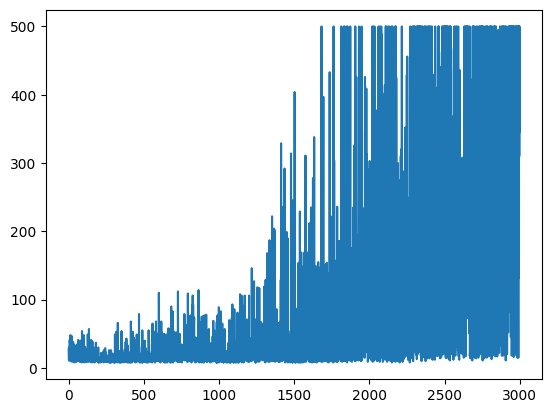

In [5]:
plt.plot(tr)

### Execução

In [6]:
tr = []     # usado para plotar o histograma
i = 0       # macete para renderizar alguns episodios

# executando sempre para 10% de passos sobre o número total de episódios usados para treinamento
for _ in tqdm.tqdm(range(int(num_eps * 0.1))):

    # ambiente a ser avaliado
    env_t = gym.make(env_name)

    # usado para plotar o gráfico de aprendizado
    r = []

    done = False

    # estado atual
    cs = discrete_state(env_t.reset())

    while not done:

        # Renderizar os ultimos 5 episodios
        #if i >= (int(num_eps * 0.1) - 5):
            #env_t.render()

        action = np.argmax(qtable[cs])
        obs, reward, done, _ = env_t.step(action)
        new_state = discrete_state(obs)
        cs = new_state
        r.append(reward)

    i += 1
    env_t.close()
    tr.append(sum(r))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 68.84it/s]


### Histograma da execução

(array([ 30.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 270.]),
 array([ 11. ,  59.9, 108.8, 157.7, 206.6, 255.5, 304.4, 353.3, 402.2,
        451.1, 500. ]),
 <BarContainer object of 10 artists>)

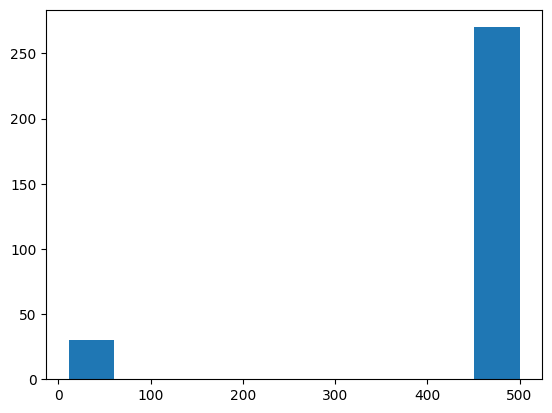

In [7]:
plt.hist(tr)